# **INITIALIZATION**

In [2]:
# My changes
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set(style="whitegrid", context="paper", rc={"axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12})
# sns.set_theme()
# URL to get raw CSV data from GitHub
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Dataset_Uncleaned.csv"
df_unclean = pd.read_csv("Sales_Dataset_Uncleaned.csv")
df_unclean.head()

,Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


# **DATA CLEANING**

In [4]:
df_unclean.columns = df_unclean.columns.str.strip().str.lower().str.replace(" ", "_")
df_unclean.drop_duplicates(inplace=True)

num_cols = ['quantity', 'unit_price', 'discount', 'sales', 'profit']
df_unclean['order_date'] = pd.to_datetime(df_unclean['order_date'], errors='coerce')
df_unclean[num_cols] = df_unclean[num_cols].apply(pd.to_numeric, errors='coerce')

# missing value handles
for col in num_cols:
    df_unclean[col] = df_unclean[col].fillna(df_unclean[col].median())

cat_cols = ['customer_name','region','city','category','sub-category',
            'product_name','payment_mode']
for col in cat_cols:
    df_unclean[col] = df_unclean[col].fillna('Unknown')

# data uniformity
df_unclean['profit_margin'] = (df_unclean['profit'] / df_unclean['sales'])*100
df_unclean['category'] = df_unclean['category'].str.title()
df_unclean['sub-category'] = df_unclean['sub-category'].str.title()
df_unclean['city'] = df_unclean['city'].str.title()
df_unclean['region'] = df_unclean['region'].str.title()
df_unclean['payment_mode'] = df_unclean['payment_mode'].str.title()
df_unclean['order_month_name'] = df_unclean['order_date'].dt.month_name()
df_unclean['order_month_num'] = df_unclean['order_date'].dt.month


# data outliners
q99 = df_unclean['quantity'].quantile(0.99)
df_unclean['quantity'] = df_unclean['quantity'].clip(upper=q99)
p99 = df_unclean['unit_price'].quantile(0.99)
df_unclean['unit_price'] = df_unclean['unit_price'].clip(upper=p99)

# save
df_unclean.to_csv("Sales_Cleaned.csv", index=False)
# files.download("Sales_Cleaned.csv")

print(df_unclean.info())
print(df_unclean.isna().sum())
df_unclean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          5000 non-null   int64         
 1   order_date        5000 non-null   datetime64[ns]
 2   customer_name     5000 non-null   object        
 3   region            5000 non-null   object        
 4   city              5000 non-null   object        
 5   category          5000 non-null   object        
 6   sub-category      5000 non-null   object        
 7   product_name      5000 non-null   object        
 8   quantity          5000 non-null   int64         
 9   unit_price        5000 non-null   float64       
 10  discount          5000 non-null   int64         
 11  sales             5000 non-null   float64       
 12  profit            5000 non-null   float64       
 13  payment_mode      5000 non-null   object        
 14  profit_margin     5000 n

,order_id,order_date,customer_name,region,city,category,sub-category,product_name,quantity,unit_price,discount,sales,profit,payment_mode,profit_margin,order_month_name,order_month_num
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294.0,5,68958.6,10525.09,Debit Card,15.262911,October,10
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165.0,20,33732.0,6299.66,Debit Card,18.675620,August,8
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876.0,20,207603.2,19850.27,Credit Card,9.561640,November,11
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320.0,15,158610.0,36311.02,Upi,22.893273,May,5
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037.0,10,45033.3,9050.04,Debit Card,20.096329,January,1


# **EXPLORATION FUNCTIONS**

## **TIME-BASED FUNCTIONS**

In [5]:
def sales_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    return df_copy.groupby("year")["sales"].sum()

def profit_margin_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    yearly = df_copy.groupby("year")[["sales", "profit"]].sum()
    yearly["profit_margin"] = yearly["profit"] / yearly["sales"]
    return yearly["profit_margin"]



# **EXPLORATION**

/tmp/ipykernel_85059/1380061859.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)


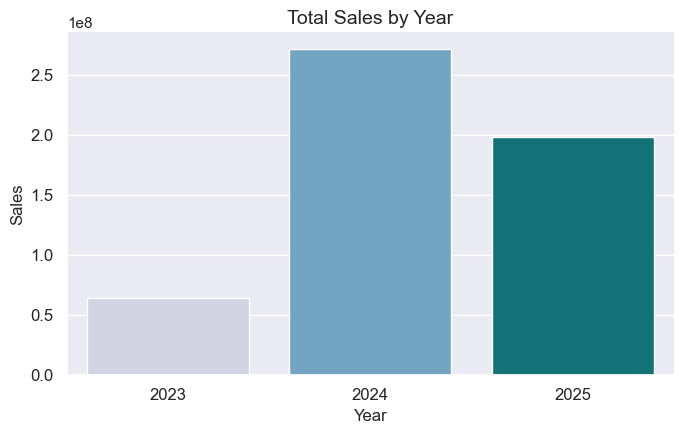

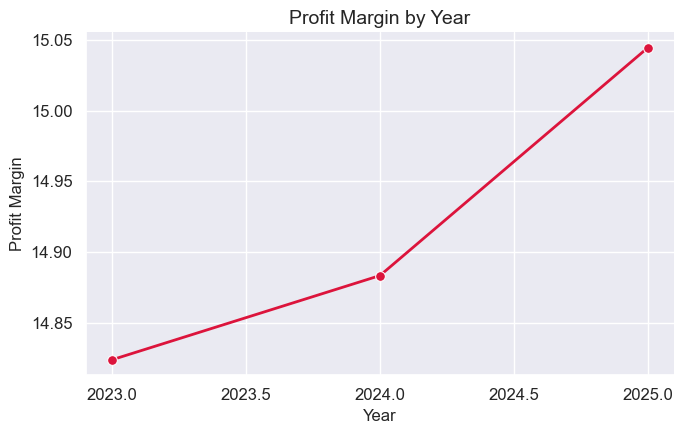

In [14]:
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Cleaned.csv"
df_clean = pd.read_csv(url)
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

df_clean.head()

# plot sales by year
def plot_sales_by_year(df_clean):
    yearly_sales = sales_by_year(df_clean)

    plt.figure(figsize=(7, 4.5))
    sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)

    plt.title("Total Sales by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Sales", fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    sns.despine()
    plt.tight_layout()
    plt.show()

#plot profit margin by year
def plot_profit_margin_by_year(df_clean):
    yearly_margin = profit_margin_by_year(df_clean)
    plt.figure(figsize=(7.01, 4.5))
    sns.lineplot(x=yearly_margin.index, y=yearly_margin.values*100, marker='o', linewidth=2,
        markersize=7, color="crimson")

    plt.title("Profit Margin by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Profit Margin", fontsize=12)

    plt.xticks([2023, 2023.5, 2024, 2024.5, 2025])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    sns.despine()
    plt.tight_layout()
    plt.show()

plot_sales_by_year(df_clean,)
plot_profit_margin_by_year(df_clean)